In [96]:
import numpy as np
import argparse
import matplotlib.pyplot as plt

In [97]:
#The algorithms and simulator consider the following hyper parameters: number of articles, number of users, number of iterations, ε (in ε-greedy), c (in UCB), and Q0 (initial reward). 

args = argparse.ArgumentParser()
args.add_argument("--num_articles", type=int, default=100)
args.add_argument("--num_users", type=int, default=100)
args.add_argument("--num_iterations", type=int, default=1000)
args.add_argument("--epsilon", type=float, default=0.1)
args.add_argument("--c", type=float, default=2)
args.add_argument("--q0", type=float, default=1)
args = args.parse_args([])


In [98]:
"""
MAB simulator
"""
class MABSimulator:
    def __init__(self, num_articles, num_users):
        self.num_articles = num_articles
        self.num_users = num_users
        self.means = np.random.uniform(1, 5, (num_users, num_articles))
        self.variances = np.random.uniform(0, 1, (num_users, num_articles))

        #print("Means: ", self.means)

    def get_reward(self, article_index, user_index):
        return np.random.normal(self.means[user_index, article_index], np.sqrt(self.variances[user_index, article_index]))

#MABSimulator(args.num_articles, args.num_users)
   

In [99]:
class MAB:
    def __init__(self, simulator, num_articles, num_users, num_iterations, method, epsilon = 0.1, c = 2, Q0 = 1):
        #self.simulator = MABSimulator(num_articles, num_users)

        self.simulator = simulator
        self.num_articles = num_articles
        self.num_users = num_users
        self.num_iterations = num_iterations
        self.method = method
        self.epsilon = epsilon
        self.c = c
        self.Q0 = np.full((num_users, num_articles), Q0)

    def select_action(self, user_index, action_values, selection_counts):
        if self.method == 'greedy':
            return np.argmax(action_values[user_index])
        elif self.method == 'epsilon_greedy':
            if np.random.rand() < self.epsilon:
                return np.random.randint(self.num_articles)
            else:
                return np.argmax(action_values[user_index])
            
        elif self.method == 'ucb':
            # selection_counts here need to add 1 to avoid division by zero, because it is initialized with zeros
            upper_bound = self.c * np.sqrt(np.log(self.num_iterations) / (selection_counts[user_index] + 1))
            return np.argmax(action_values[user_index] + upper_bound)
        

    def run(self):
        action_values = np.copy(self.Q0)
        selection_counts = np.zeros((self.num_users, self.num_articles))
        total_rewards = np.zeros(self.num_iterations)

        for i in range(self.num_iterations):
            rewards_for_iteration = 0
            for user_index in range(self.num_users):
                action = self.select_action(user_index, action_values, selection_counts)
                reward = self.simulator.get_reward(action, user_index)
                selection_counts[user_index, action] += 1
                action_values[user_index, action] += (reward - action_values[user_index, action]) / selection_counts[user_index, action]
                rewards_for_iteration += reward

            total_rewards[i] = rewards_for_iteration / self.num_users

        return total_rewards


In [100]:
# greedy = MAB(args.num_articles, args.num_users, args.num_iterations, 'greedy')
# #print("Greedy: ", greedy.run())

# epsilon_greedy = MAB(args.num_articles, args.num_users, args.num_iterations, 'epsilon_greedy', epsilon=args.epsilon)
# #print("Epsilon Greedy: ", epsilon_greedy.run())

# ucb = MAB(args.num_articles, args.num_users, args.num_iterations, 'ucb', c=args.c)
# #print("UCB: ", ucb.run())

# create a simulator to make sure all algorithms use the same simulator
simulator = MABSimulator(args.num_articles, args.num_users)

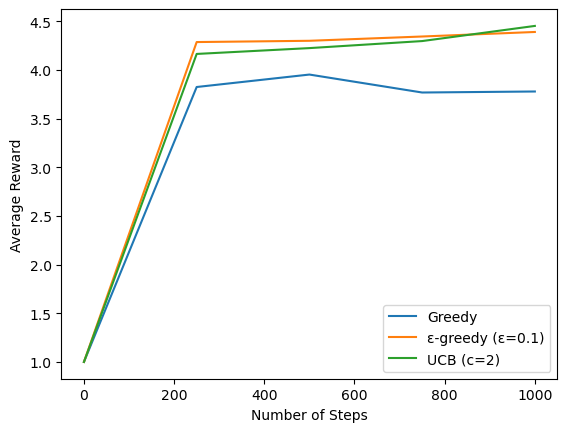

In [101]:
#Average reward vs. number of steps (0 to 1K, step size 250)
num_articles = args.num_articles
num_users = args.num_users
#num_iterations = args.num_iterations
epsilon = args.epsilon
c = args.c
q0 = args.q0
step_sizes = [0, 250, 500, 750, 1000]


rewards = {
    'greedy': [],
    'epsilon_greedy': [],
    'ucb': [],
}

for num_iterations in step_sizes:
    if num_iterations == 0:
        rewards['greedy'].append(q0)
        rewards['epsilon_greedy'].append(q0)
        rewards['ucb'].append(q0)
    else:
        greedy = MAB(simulator, num_articles, num_users, num_iterations, "greedy", Q0=q0)
        rewards['greedy'].append(greedy.run()[-1])

        epsilon_greedy = MAB(simulator, num_articles, num_users, num_iterations, "epsilon_greedy", epsilon=epsilon, Q0=q0)
        rewards['epsilon_greedy'].append(epsilon_greedy.run()[-1])

        ucb = MAB(simulator, num_articles, num_users, num_iterations, "ucb", c=c, Q0=q0)
        rewards['ucb'].append(ucb.run()[-1])

# Plotting
plt.plot(step_sizes, rewards['greedy'], label="Greedy")
plt.plot(step_sizes, rewards['epsilon_greedy'], label=f"ε-greedy (ε={epsilon})")
plt.plot(step_sizes, rewards['ucb'], label=f"UCB (c={c})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')
plt.legend()

plt.show()

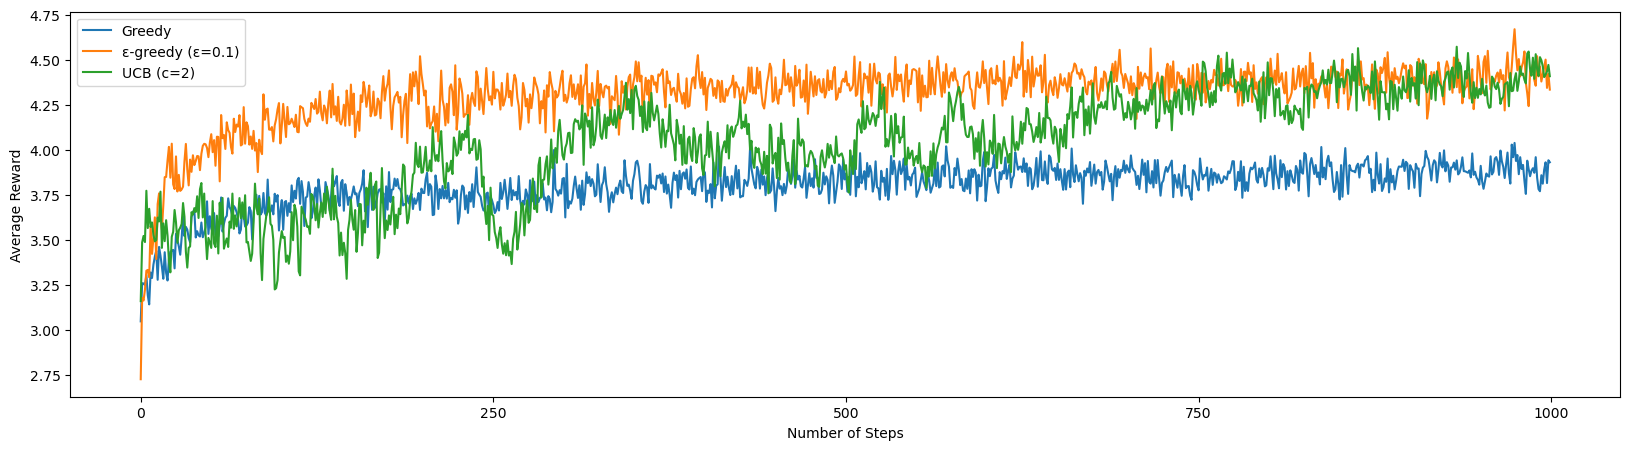

In [102]:
num_articles = args.num_articles
num_users = args.num_users
num_iterations = args.num_iterations

epsilon = args.epsilon
c = args.c
Q0 = args.q0

greedy = MAB(simulator, num_articles, num_users, num_iterations, "greedy", Q0=Q0)
rewards_greedy = greedy.run()

epsilon_greedy = MAB(simulator, num_articles, num_users, num_iterations, "epsilon_greedy", epsilon=epsilon, Q0=Q0)
rewards_epsilon_greedy = epsilon_greedy.run()

ucb = MAB(simulator, num_articles, num_users, num_iterations, "ucb", c=c, Q0=Q0)
rewards_ucb = ucb.run()

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(range(num_iterations), rewards_greedy, label="Greedy")
plt.plot(range(num_iterations), rewards_epsilon_greedy, label=f"ε-greedy (ε={epsilon})")
plt.plot(range(num_iterations), rewards_ucb, label=f"UCB (c={c})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')

# Set custom x-axis labels
plt.xticks([0, 250, 500, 750, 1000])
plt.legend()

plt.show()


C:\Users\jixua\AppData\Local\Temp\ipykernel_24196\60941620.py:22: RuntimeWarning: divide by zero encountered in divide
  return np.argmax(action_values[user_index] + self.c * np.sqrt(np.log(self.num_iterations)) / (action_values[user_index] + 1))


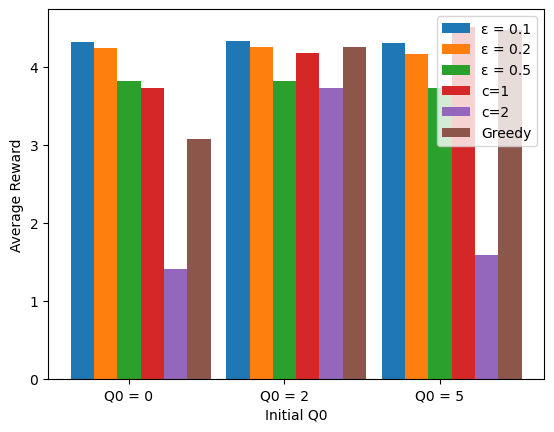

In [30]:
num_articles = args.num_articles
num_users = args.num_users
num_iterations = args.num_iterations

epsilon_values = [0.1, 0.2, 0.5]
c_values = [1, 2]
Q0_values = [0, 2, 5]

results = {
    'greedy': [],
    'epsilon_greedy': [],
    'ucb': [],
}

for Q0 in Q0_values:
    greedy = MAB(simulator, num_articles, num_users, num_iterations, 'greedy', Q0=Q0)
    # report average reward over 1K first steps
    results['greedy'].append(np.mean(greedy.run()[:1000]))

    for epsilon in epsilon_values:
        epsilon_greedy = MAB(simulator, num_articles, num_users, num_iterations, 'epsilon_greedy', epsilon=epsilon, Q0=Q0)
        # report average reward over 1K first steps
        results['epsilon_greedy'].append(np.mean(epsilon_greedy.run()[:1000]))

    for c in c_values:
        ucb = MAB(simulator, num_articles, num_users, num_iterations, 'ucb', c=c, Q0=Q0)
        # report average reward over 1K first steps
        results['ucb'].append(np.mean(ucb.run()[:1000]))


# Plot the results
fig, ax = plt.subplots()
x_labels = []

for Q0 in Q0_values:
    x_labels.append(f'Q0 = {Q0}')

bar_width = 0.15
index = np.arange(len(x_labels))

for i, epilson in enumerate(epsilon_values):
    ax.bar(index + i * bar_width, results['epsilon_greedy'][i::3], bar_width, label=f'ε = {epilson}')
for i, c in enumerate(c_values):
    ax.bar(index + (i + len(epsilon_values)) * bar_width, results['ucb'][i::2], bar_width, label=f"c={c}")

ax.bar(index + (len(epsilon_values) + len(c_values)) * bar_width, results['greedy'], bar_width, label="Greedy")

ax.set_xlabel('Initial Q0')
ax.set_ylabel('Average Reward')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(x_labels)
ax.legend()

plt.show()

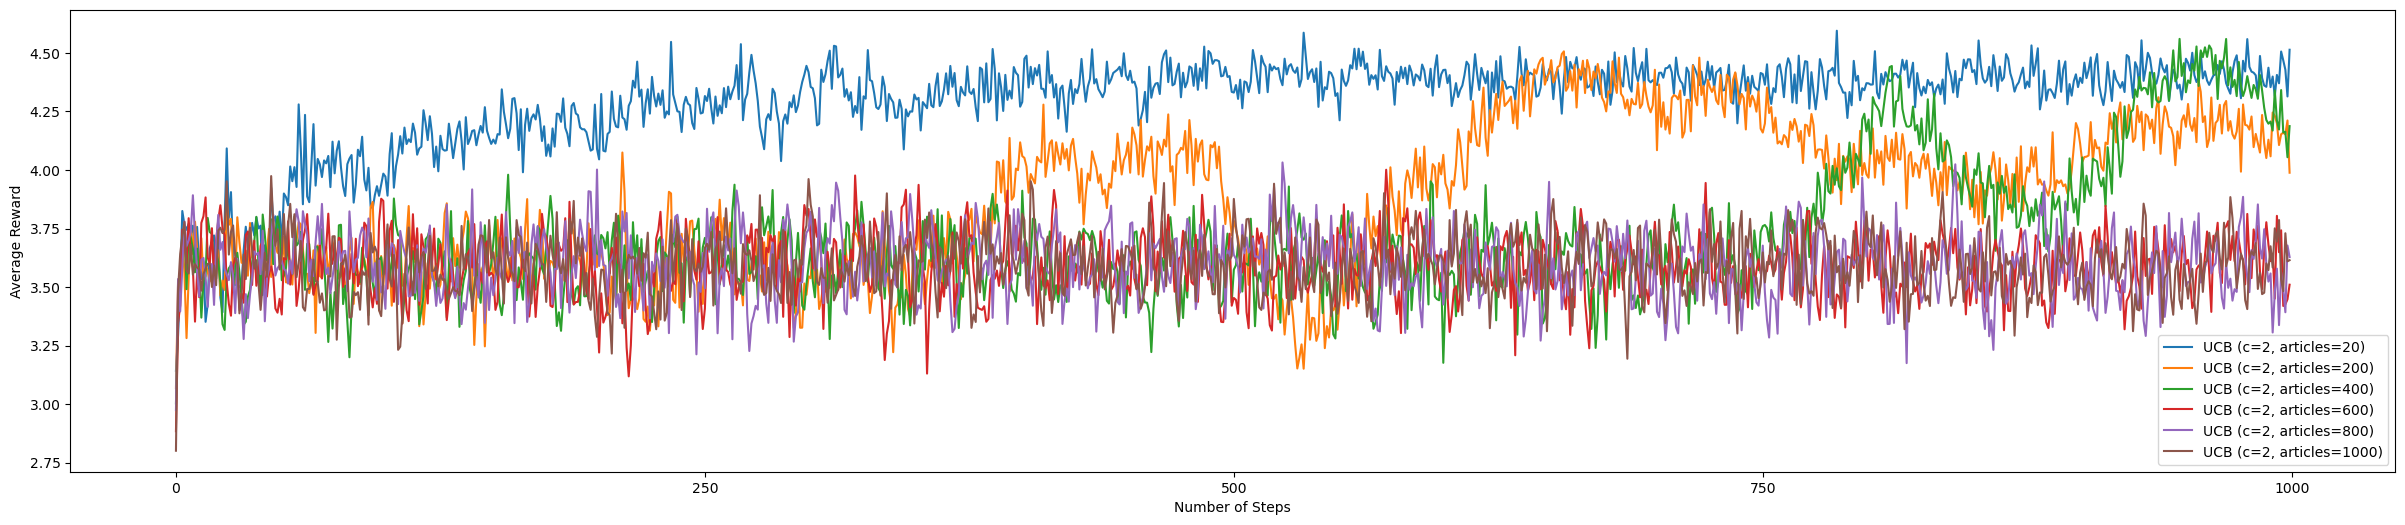

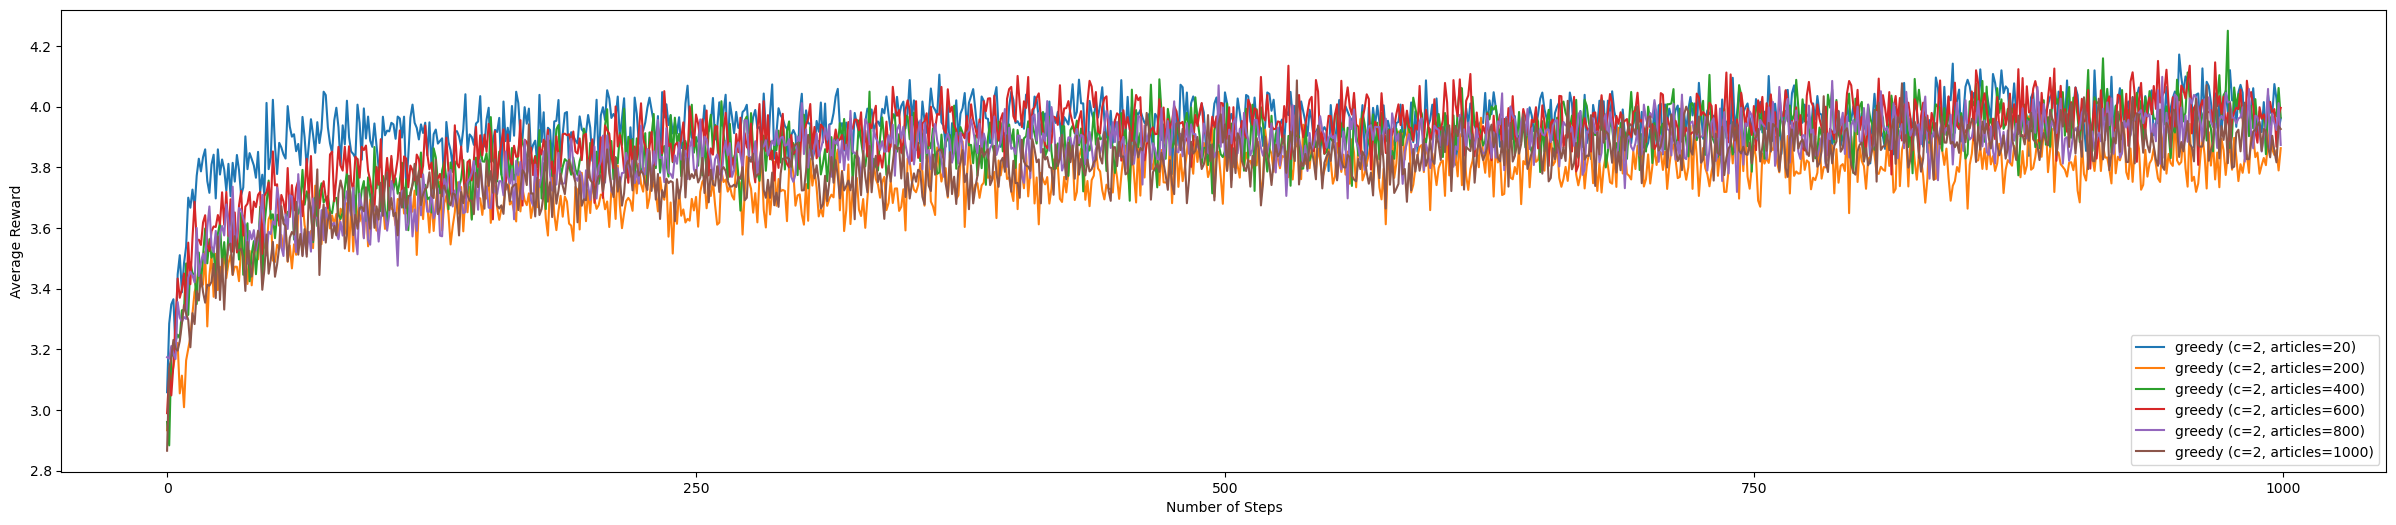

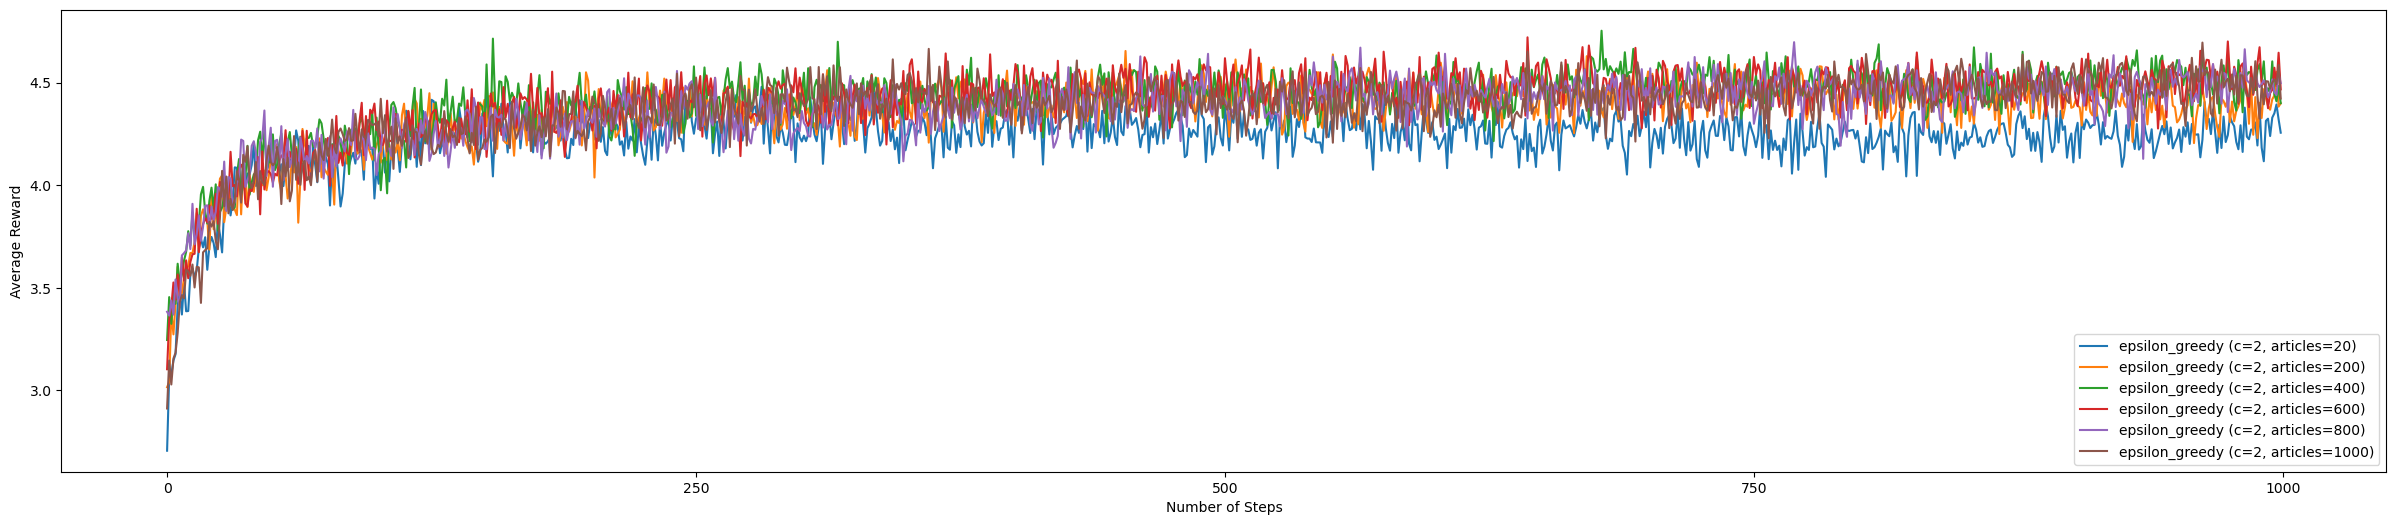

In [77]:
#Average reward over 1K first steps vs. number of articles (20, 200, 400, 600, 800, 1K)

num_users = args.num_users
num_iterations = args.num_iterations
num_articles = [20, 200, 400, 600, 800, 1000]

epsilon = args.epsilon
c = args.c
Q0 = args.q0

rewards = {
    'greedy': [],
    'epsilon_greedy': [],
    'ucb': [],
}


for article in num_articles:
    ucb = MAB(simulator, article, num_users, num_iterations, "ucb", c=c, Q0=Q0)
    rewards['ucb'].append(ucb.run())

    epsilon_greedy = MAB(simulator, article, num_users, num_iterations, "epsilon_greedy", epsilon=epsilon, Q0=Q0)
    rewards['epsilon_greedy'].append(epsilon_greedy.run())

    greedy = MAB(simulator, article, num_users, num_iterations, "greedy", Q0=Q0)
    rewards['greedy'].append(greedy.run())

# Set the figure size (width, height)
plt.figure(figsize=(30, 6))

# Plotting separate lines for each article size
for i, article in enumerate(num_articles):
    plt.plot(range(num_iterations), rewards['ucb'][i], label=f"UCB (c={c}, articles={article})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')

# Set custom x-axis labels
plt.xticks([0, 250, 500, 750, 1000])
plt.legend()
plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(30, 6))
for i, article in enumerate(num_articles):
    plt.plot(range(num_iterations), rewards['greedy'][i], label=f"greedy (c={c}, articles={article})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')

# Set custom x-axis labels
plt.xticks([0, 250, 500, 750, 1000])
plt.legend()
plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(30, 6))
for i, article in enumerate(num_articles):
    plt.plot(range(num_iterations), rewards['epsilon_greedy'][i], label=f"epsilon_greedy (c={c}, articles={article})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')

# Set custom x-axis labels
plt.xticks([0, 250, 500, 750, 1000])
plt.legend()
plt.show()


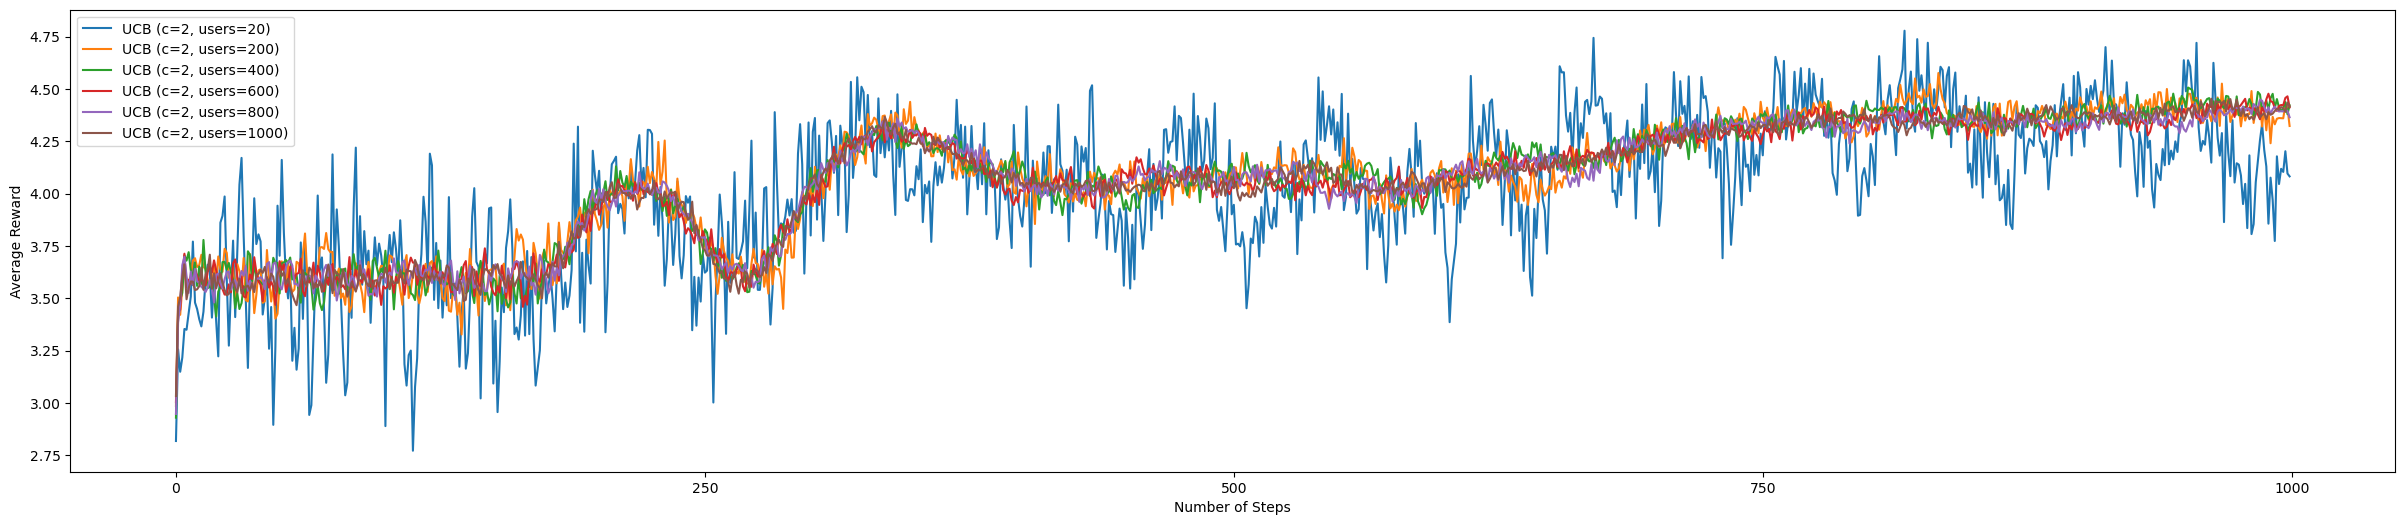

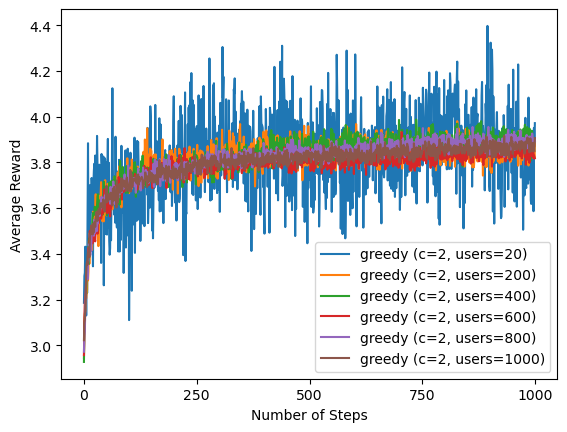

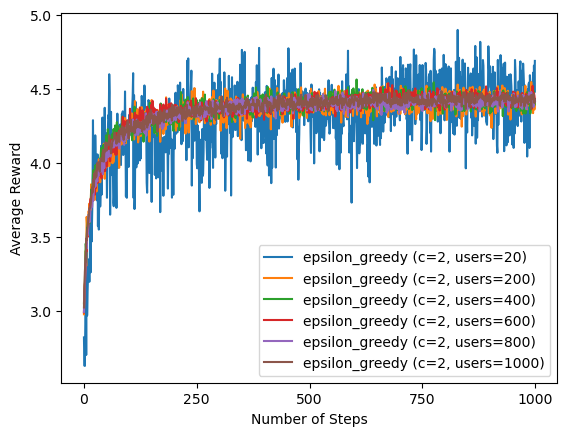

In [78]:
#Average reward over 1K first steps vs. number of users (20, 200, 400, 600, 800, 1K)

num_users = [20, 200, 400, 600, 800, 1000]
num_iterations = args.num_iterations
num_articles = args.num_articles

epsilon = args.epsilon
c = args.c
Q0 = args.q0

rewards = {
    'greedy': [],
    'epsilon_greedy': [],
    'ucb': [],
}

for user in num_users:
    ucb = MAB(simulator, num_articles, user, num_iterations, "ucb", c=c, Q0=Q0)
    rewards['ucb'].append(ucb.run())

    epsilon_greedy = MAB(simulator, num_articles, user, num_iterations, "epsilon_greedy", epsilon=epsilon, Q0=Q0)
    rewards['epsilon_greedy'].append(epsilon_greedy.run())

    greedy = MAB(simulator, num_articles, user, num_iterations, "greedy", Q0=Q0)
    rewards['greedy'].append(greedy.run())

# Set the figure size (width, height)
plt.figure(figsize=(30, 6))

# Plotting separate lines for each article size
for i, user in enumerate(num_users):
    plt.plot(range(num_iterations), rewards['ucb'][i], label=f"UCB (c={c}, users={user})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')

# Set custom x-axis labels
plt.xticks([0, 250, 500, 750, 1000])
plt.legend()
plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting separate lines for each article size
for i, user in enumerate(num_users):
    plt.plot(range(num_iterations), rewards['greedy'][i], label=f"greedy (c={c}, users={user})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')

# Set custom x-axis labels
plt.xticks([0, 250, 500, 750, 1000])
plt.legend()
plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting separate lines for each article size
for i, user in enumerate(num_users):
    plt.plot(range(num_iterations), rewards['epsilon_greedy'][i], label=f"epsilon_greedy (c={c}, users={user})")

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')

# Set custom x-axis labels
plt.xticks([0, 250, 500, 750, 1000])
plt.legend()
plt.show()